<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
The project is accepted! Good luck on the next sprint!
	  
</div>

**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall, there's only one small problem that needs to be fixed before the project can be accepted. Good luck!

# Predicting Taxi Orders using Machine Learning

**Project Description**

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

**Project Instructions**

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

**Data Description**

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = 'datetime')
taxi.sort_index(inplace = True)
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# check if dates are in chronological order

taxi.index.is_monotonic

True

In [5]:
# resample data by one hour

taxi = taxi.resample('1H').sum()

taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Conclusion**

We uploaded data from a taxi company that contains the dates and times of taxi orders. The data consists of 26496 entries. There are no missing values. We prepared data by changing dates to datatype datetime and made sure data was in chronologic order. We resampled data by one hour. We will analyze data next.  

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you loaded the data, checked that it's sorted in chronological order and correctly resampled it
	  
</div>

## Analysis

### Rolling Mean

In [6]:
taxi['rolling_mean'] = taxi.rolling(20).mean()
taxi = taxi.dropna()

print(taxi)

                     num_orders  rolling_mean
datetime                                     
2018-03-01 19:00:00          45         53.30
2018-03-01 20:00:00          61         50.15
2018-03-01 21:00:00          66         49.20
2018-03-01 22:00:00         113         51.30
2018-03-01 23:00:00          58         50.90
...                         ...           ...
2018-08-31 19:00:00         136        163.85
2018-08-31 20:00:00         154        157.75
2018-08-31 21:00:00         159        156.00
2018-08-31 22:00:00         223        155.65
2018-08-31 23:00:00         205        160.95

[4397 rows x 2 columns]


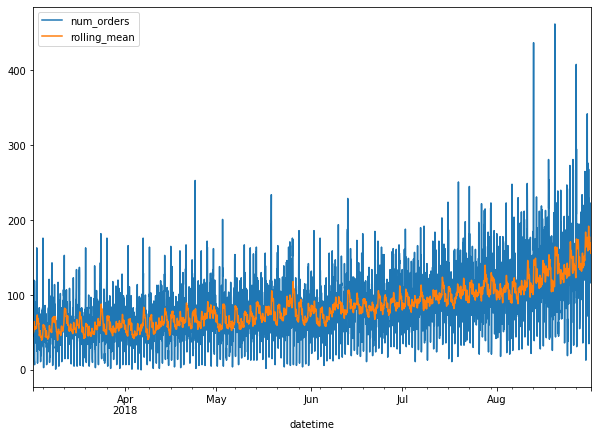

In [7]:
taxi.plot(figsize = (10, 7))

We plotted the rolling mean per day for our data. The graph shows that there is a increase in orders from March to August, 2018.

### Trends and Seasonality

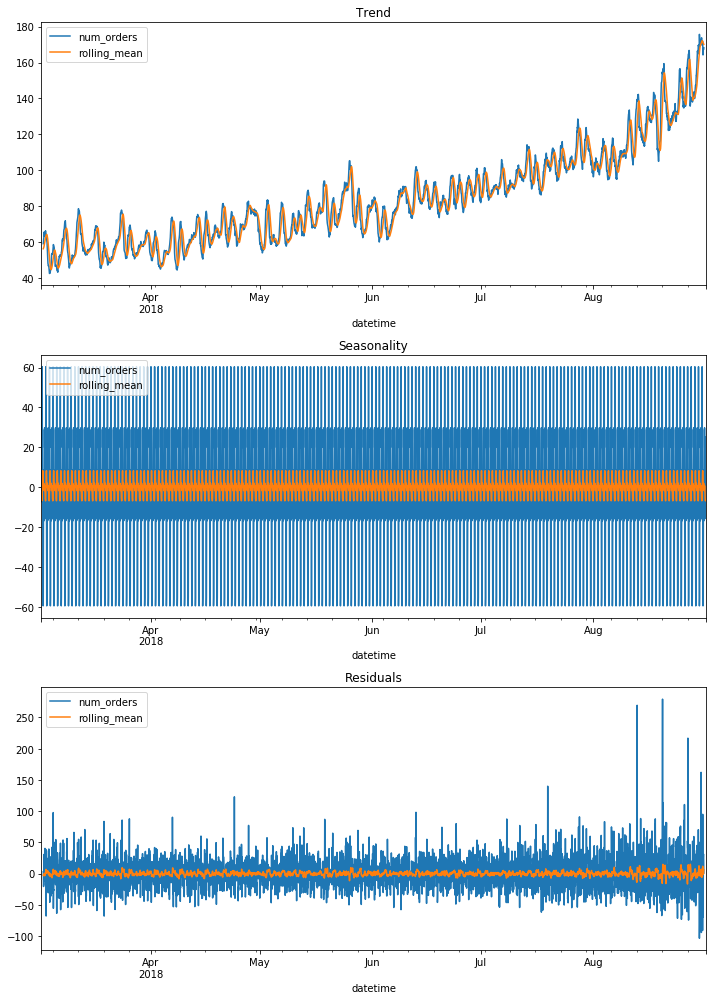

In [8]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(10, 14))
plt.subplot(311)

# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Looking at Seasonality for One Week and One Day

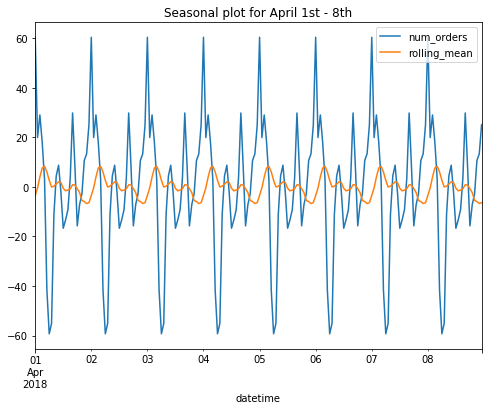

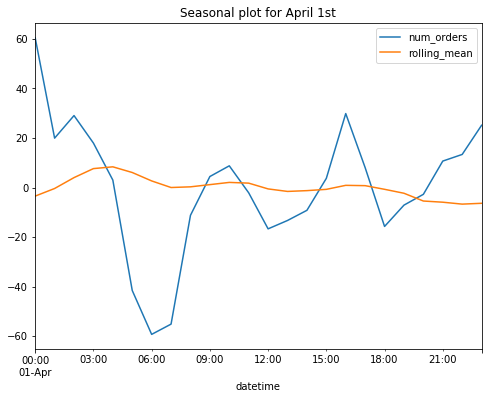

In [9]:
#taxi orders from April 1st-8th, 2018
decomposed.seasonal['2018-04-01':'2018-04-08'].plot(figsize=(8, 6))
plt.title('Seasonal plot for April 1st - 8th');

#taxi orders on April 1st
decomposed.seasonal['2018-04-01'].plot(figsize=(8, 6))
plt.title('Seasonal plot for April 1st');

We looked at seasonality for the week of April 1st-8th, 2018. Taxi orders have the same pattern every day. There is a peak in taxi orders around 9am and 5pm, when travel time is busiest. 6am is when there are the least amount of taxi orders.

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
As we're doing hourly predictions, it would be probably more useful to look at the hourly data in the seasonal decomposition
	  
</div>

**Conclusion**

We looked at the rolling mean, trends, and seasonality for our data. Our rolling mean and trend graphs show the number of taxi orders increased from March to August, 2018. The seasonality graph shows a pattern that fluctuates from one season to the next. We looked at seasonality for one week and one day in April. The busiest time for taxi orders is 9am and 5pm. Now that we have analyzed the data it is ready for training.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Nice EDA! You plotted the data, did a seasonal decomposition and noted some patterns
	  
</div>

## Training

In [10]:
# function to make features
def make_features(taxi, max_lag, rolling_mean_size):
    taxi['month'] = taxi.index.month
    taxi['day'] = taxi.index.day
    taxi['dayofweek'] = taxi.index.dayofweek
    taxi['hour'] = taxi.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
    
    taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_mean_size).mean()# < write code here >

make_features(taxi, 6, 10)

taxi.sample(5)

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
datetime,,,,,,,,,,,,
2018-07-09 11:00:00,73,91.9,7,9,0,11,122.0,95.0,92.0,38.0,13.0,61.0
2018-08-14 21:00:00,119,112.2,8,14,1,21,84.0,109.0,98.0,152.0,111.0,116.0
2018-06-14 03:00:00,115,94.1,6,14,3,3,148.0,58.0,162.0,69.0,70.0,104.0
2018-05-18 13:00:00,85,63.3,5,18,4,13,49.0,102.0,102.0,80.0,84.0,18.0
2018-05-15 17:00:00,53,68.3,5,15,1,17,130.0,66.0,68.0,82.0,41.0,71.0


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Feature engineering looks good!
	  
</div>

In [11]:
# split data into training and test set
train, test = train_test_split(taxi, shuffle=False, test_size=0.1, random_state = 123)
train = train.dropna()

display(train.shape)
display(test.shape)

(3947, 12)

(440, 12)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data was split into train and test without shuffling!
    
	  
</div>

In [12]:
# declare variables for features and target

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']


In [13]:
# time series split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [14]:
%%time

# baseline model with previous value as prediction
pred_previous = test.shift(fill_value = train['num_orders'].iloc[-1])
print('RMSE:, {:.2f}'.format(np.sqrt(mean_squared_error(pred_previous['num_orders'], test['num_orders']))))

RMSE:, 58.88
CPU times: user 3 ms, sys: 319 µs, total: 3.32 ms
Wall time: 36.6 ms


### Linear Regression

In [15]:
%%time

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

CPU times: user 2 ms, sys: 3.4 ms, total: 5.4 ms
Wall time: 3.62 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Random Forest Regressor

In [16]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
grid = {
    "n_estimators" : [10, 25, 50, 100],
    "max_depth" : [None, 2, 4, 8],
    "min_samples_leaf" : [2, 4, 6]
}
# define the model 
regressor = RandomForestRegressor(random_state = 123)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, param_grid = grid, scoring="neg_mean_squared_error", cv=tscv)
# execute search
grid_search_rf.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf.best_params_))

The best hyperparameters are: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 100}
CPU times: user 1min 11s, sys: 237 ms, total: 1min 12s
Wall time: 1min 12s


In [17]:
%%time

rf_model = RandomForestRegressor(**grid_search_rf.best_params_)
rf_model.fit(features_train, target_train)

CPU times: user 1.86 s, sys: 36 µs, total: 1.86 s
Wall time: 1.87 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

### CatBoost Regressor

In [18]:
%%time
# hyperparameter optimization

# define hyperparameters to tune
cb_grid = {'learning_rate': [0.01, 0.1],
        'depth': [2, 6, 10],
        'l2_leaf_reg': [1, 3, 5]
       }
# define the model 
cb_regr = CatBoostRegressor(
    iterations=100,
    logging_level = 'Silent',
    loss_function='RMSE',
    early_stopping_rounds = 50,
    random_state = 123)
# define the grid search
grid_search_cb = GridSearchCV(estimator = cb_regr, param_grid = cb_grid, scoring="neg_mean_squared_error", cv=tscv)
# execute search
grid_search_cb.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_cb.best_params_))

The best hyperparameters are: {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CPU times: user 4min 15s, sys: 30.1 s, total: 4min 45s
Wall time: 6min 48s


In [19]:
%%time

cb_model = CatBoostRegressor(**grid_search_cb.best_params_)
cb_model.fit(features_train, target_train, eval_set=(features_test,target_test), verbose = False)

CPU times: user 30.9 s, sys: 4.2 s, total: 35.1 s
Wall time: 37 s


### XGBoost Regressor

In [20]:
%%time
# hyperparameter optimization for XGBoost

# define hyperparameters to tune
xgb_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.3], 
            'max_depth': [2, 4, 6, 10],
            'n_estimators': [25, 50, 100, 200]
           }
# define the model 
xgb_regr = XGBRegressor(random_state = 123)

# define the grid search
grid_search_xgb = GridSearchCV(
    estimator = xgb_regr, 
    param_grid = xgb_grid, 
    scoring = "neg_mean_squared_error",
    cv = tscv,
    n_jobs = 1
)
# execute search
grid_search_xgb.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_xgb.best_params_))

[23:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:39:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [21]:
%%time

xgb_model = XGBRegressor(**grid_search_xgb.best_params_)
xgb_model.fit(features_train, target_train)

[23:41:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 351 ms, sys: 6.96 ms, total: 358 ms
Wall time: 372 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

### LightGBM Regressor

In [22]:
%%time
# hyperparameter optimization for LightGBM regression

# define hyperparameters to tune
lgbm_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1],
             'n_estimators': [50, 100, 500],
             'num_leaves': [5, 10, 20, 31]
            }
# define the model 
lgbm_regr = LGBMRegressor(random_state = 123)

# define the grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "neg_mean_squared_error", 
    cv = tscv, 
    n_jobs = 1
)
# execute search
grid_search_lgbm.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_lgbm.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 10}
CPU times: user 47.7 s, sys: 1.76 s, total: 49.5 s
Wall time: 50.4 s


In [23]:
%%time

lgbm_model = LGBMRegressor(**grid_search_lgbm.best_params_)
lgbm_model.fit(features_train, target_train)

CPU times: user 89.4 ms, sys: 8.19 ms, total: 97.6 ms
Wall time: 171 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

**Conclusion**

Our baseline model with previous values as predictions has a RMSE score of 58.88. We trained multiple models with different hyperparameters. The model we trained are Linear Regressor, Random Forest Regressor, CatBoost Regressor, LightGBM Regressor, and XGBoost Regressor. We observed the time to tune and train the models. The fastest trained model with hyperparameter tuning was the LightGBM Regressor.

## Testing

### Linear Regression

In [24]:
%%time

lr_predict = lr_model.predict(features_test)

lr_rmse = np.sqrt(mean_squared_error(target_test, lr_predict))
print('RMSE Linear Regression Model: {:.2f}'.format(lr_rmse))

RMSE Linear Regression Model: 53.11
CPU times: user 3.12 ms, sys: 0 ns, total: 3.12 ms
Wall time: 2.49 ms


### Random Forest Regressor

In [25]:
%%time

rf_predict = rf_model.predict(features_test)
rf_rmse = np.sqrt(mean_squared_error(target_test, rf_predict))
print('RMSE Random Forest Regressor Model: {:.2f}'.format(rf_rmse))

RMSE Random Forest Regressor Model: 44.66
CPU times: user 19 ms, sys: 0 ns, total: 19 ms
Wall time: 17.9 ms


### CatBoost Regressor

In [26]:
%%time

cb_predict = cb_model.predict(features_test)
cb_rmse = np.sqrt(mean_squared_error(target_test, cb_predict))
print('RMSE CatBoost Regressor Model: {:.2f}'.format(cb_rmse))

RMSE CatBoost Regressor Model: 43.51
CPU times: user 5.07 ms, sys: 3.36 ms, total: 8.43 ms
Wall time: 3.57 ms


### XGBoost Regressor

In [27]:
%%time

xgb_predict = xgb_model.predict(features_test)
xgb_rmse = np.sqrt(mean_squared_error(target_test, xgb_predict))
print('RMSE XGBoost Regressor Model: {:.2f}'.format(xgb_rmse))

RMSE XGBoost Regressor Model: 43.71
CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 4.33 ms


### LightGBM Regressor

In [28]:
%%time

lgbm_predict = lgbm_model.predict(features_test)
lgbm_rmse = np.sqrt(mean_squared_error(target_test, lgbm_predict))
print('RMSE LightGBM Regressor Model: {:.2f}'.format(lgbm_rmse))

RMSE LightGBM Regressor Model: 43.97
CPU times: user 10.8 ms, sys: 169 µs, total: 10.9 ms
Wall time: 10.1 ms


**Conclusion**

We tested our models and found the rmse score with the test data. The Linear Regression model's RMSE was higher than our target score of 48. The model with the lowest RMSE score was CatBoost Regressor. The LightGBM Regressor was the fastest model when training. The XGBoost Model had the fastest prediction time.

<div class="alert alert-danger">
<s>
    <b>Reviewer's comment</b>
	  
It's great that you tried several different models and tuned their hyperparameters. There's one small problem though: regular k-fold cross-validation is problematic for time series models, because in all folds but one there is data leakage that occurs due to some of train data being chronologically after the validation data for the fold. For correct cross-validation, we need to use something like [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) instead.
	  
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Fixed!
	  
</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>
	  
It would be great if you added a simple baseline, like a model using a previous value as prediction.
	  
</div>

## Conclusion

Our data consists of dates and times of taxi orders. To make data more readable we changed the datatype in datetime and resampled our data by one hour. We analyzed our data by viewing graphs for the rolling mean, trends, and seasonality of our data. The rolling mean and trend graphs show the number of taxi orders increased from March to August, 2018. The seasonality graph shows a pattern that fluctuates from one season to the next.

We trained multiple models with different hyperparameters. We compared the training and prediction time along with the RMSE scores of the models. The fastest model was the LightGBM Regressor when training and the XGBoost Regressor when predicting. The best model for the task is CatBoost Regressor with the lowest RMSE score and one of the lowest model prediciton times, even if it has the highest model training and tuning time. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Ok, it's nice that you also compared the speed of the models!
	  
</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48